In [22]:
import json

from ast import literal_eval
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import pyarrow as pa

from tqdm import tqdm

tqdm.pandas()

In [23]:
DATASET_DIR = "../dataset"
DATASET_NAME = "medium_articles.parquet"
DATASET_PATH = Path(DATASET_DIR) / DATASET_NAME

assert Path(DATASET_PATH).exists(), "Dataset not found."

df = pd.read_parquet(DATASET_PATH)

In [24]:
df = df[(df["label"] == "en") & (df["score"] > 0.8)]

In [25]:
df.count()

title        189251
text         189256
url          189256
authors      189256
timestamp    189254
tags         189256
label        189256
score        189256
dtype: int64

In [26]:
label_dataset_path = Path(DATASET_DIR) / "en_labels.parquet"
label_df = pd.read_parquet(label_dataset_path)

In [27]:
df = df[~df["title"].str.lower().duplicated()]

In [28]:
df.head()

title  \
0               Mental Note Vol. 24   
1         Your Brain On Coronavirus   
2                    Mind Your Nose   
3          The 4 Purposes of Dreams   
4  Surviving a Rod Through the Head   

                                                text  \
0  Photo by Josh Riemer on Unsplash  Merry Christ...   
1  Your Brain On Coronavirus  A guide to the curi...   
2  Mind Your Nose  How smell training can change ...   
3  Passionate about the synergy between science a...   
4  You ve heard of him, haven t you  Phineas Gage...   

                                                 url                 authors  \
0  https://medium.com/invisible-illness/mental-no...            ['Ryan Fan']   
1  https://medium.com/age-of-awareness/how-the-pa...       ['Simon Spichak']   
2  https://medium.com/neodotlife/mind-your-nose-f...                      []   
3  https://medium.com/science-for-real/the-4-purp...  ['Eshan Samaranayake']   
4  https://medium.com/live-your-life-on-purpose/s...        ['Rishav Sinha']   

                          timestamp  \
0  2020-12-26 03:38:10.479000+00:00   
1  2020-09-23 22:10:17.126000+00:00   
2  2020-10-10 20:17:37.132000+00:00   
3  2020-12-21 16:05:19.524000+00:00   
4  2020-02-26 00:01:01.576000+00:00   

                                                tags label     score  
0  ['Mental Health', 'Health', 'Psychology', 'Sci...    en  0.964118  
1  ['Mental Health', 'Coronavirus', 'Science', 'P...    en  0.962439  
2  ['Biotechnology', 'Neuroscience', 'Brain', 'We...    en  0.957879  
3  ['Health', 'Neuroscience', 'Mental Health', 'P...    en  0.915634  
4  ['Brain', 'Health', 'Development', 'Psychology...    en  0.914334

In [29]:
label_df = label_df[~label_df["label"].str.lower().duplicated()]

In [30]:
label_df.count()

lang_label    78583
lang_score    78583
label         78583
index         78583
dtype: int64

In [31]:
label_vals = label_df["label"].tolist()
label_df = pd.DataFrame(
    {"index": range(1, len(label_vals) + 1), "label": label_vals},
)

In [32]:
label_df.count()

index    78583
label    78583
dtype: int64

In [12]:
import fasttext

w2v_model_path = "../checkpoints/fil9.bin"

if not Path(w2v_model_path).exists():
    w2v_model = fasttext.train_unsupervised(str(Path(DATASET_DIR) / "fil9"))
    w2v_model.save_model(w2v_model_path)
else:
    w2v_model = fasttext.load_model(w2v_model_path)

In [13]:
# import torch
# from transformers import pipeline

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# extractor = pipeline(model="bert-base-uncased", task="feature-extraction")
# embedded_array = []

# for val in tqdm(extractor(label_vals, batch_size=500, device=device), total=len(label_vals)):
#     embedded_array.append(val[0][0])

In [14]:
embedded_array = []

for val in tqdm(label_vals, total=len(label_vals)):
    vec = w2v_model.get_word_vector(val.lower())
    embedded_array.append(vec)

100%|█████████████████████████████████| 78583/78583 [00:00<00:00, 146921.34it/s]


In [15]:
from sklearn.metrics.pairwise import cosine_distances

precomputed_vec = cosine_distances(embedded_array)
del embedded_array

In [19]:
print("%d bytes" % (precomputed_vec.size * precomputed_vec.itemsize))

24701151556 bytes


In [10]:
from sklearn.manifold import TSNE

import numpy as np


tsne = TSNE(
    n_components=3,
    init="random",
    verbose=1,
    perplexity=45,
    n_iter=2500,
    metric="precomputed",
)
x_embedded = tsne.fit_transform(precomputed_vec)

/home/ntub/Documents/190k-medium-articles/.venv/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 136 nearest neighbors...
[t-SNE] Indexed 78583 samples in 4.295s...


MemoryError: Unable to allocate 46.0 GiB for an array with shape (78583, 78583) and data type int64

In [ ]:
df_embeddings = pd.DataFrame(x_embedded)
df_embeddings = df_embeddings.rename(columns={0: "x", 1: "y", 2: "z"})
df_embeddings = df_embeddings.assign(label=label_vals)

In [ ]:
df_embeddings.head()

In [261]:
from sklearn.cluster import BisectingKMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from collections import defaultdict

cosine_scores = []
euclidean_scores = []
iterators = list(range(100, 3000, 100))
kmeans_dataset = x_embedded

for n_cluster_ in tqdm(iterators):
    kmeans = BisectingKMeans(n_cluster_)
    y_kmeans = kmeans.fit_predict(kmeans_dataset)
    cosine_score = silhouette_score(
        kmeans_dataset,
        y_kmeans,
        metric="cosine",
    )
    cosine_scores.append(cosine_score)
    euclidean_score = silhouette_score(
        kmeans_dataset,
        y_kmeans,
    )
    euclidean_scores.append(euclidean_score)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [05:37<00:00, 11.63s/it]


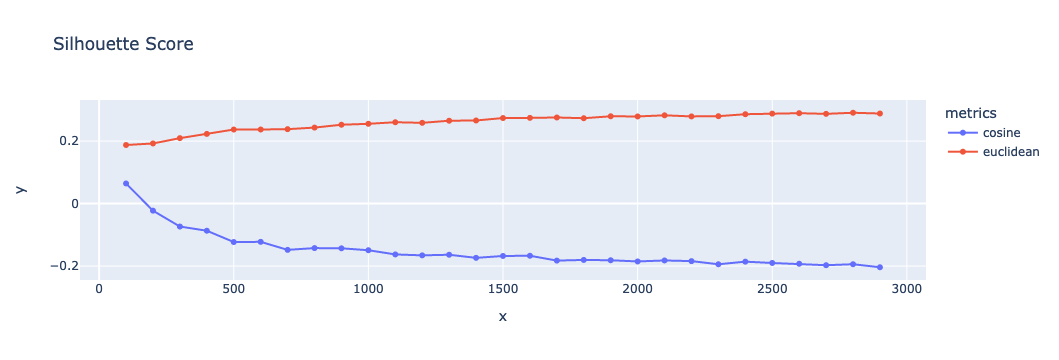

In [262]:
import plotly.express as px
import pandas as pd


df_cosine_score = pd.DataFrame(
    dict(
        x=iterators,
        y=cosine_scores,
        metrics="cosine",
    )
)
df_euclidean_score = pd.DataFrame(
    dict(
        x=iterators,
        y=euclidean_scores,
        metrics="euclidean",
    )
)

scores_df = pd.concat([df_cosine_score, df_euclidean_score], axis=0)
fig = px.line(
    scores_df,
    x="x",
    y="y",
    color="metrics",
    markers=True,
    title="Silhouette Score",
)
fig.show()

In [263]:
from sklearn.cluster import BisectingKMeans
from collections import defaultdict

cluster_model = BisectingKMeans(1000)
y_cluster = cluster_model.fit_predict(x_embedded)
output_dict = defaultdict(set)
for i, j in enumerate(y_cluster):
    output_dict[j].add(label_vals[i])

In [264]:
df_k_embeddings = df_embeddings.assign(k=list(map(str, y_cluster)))

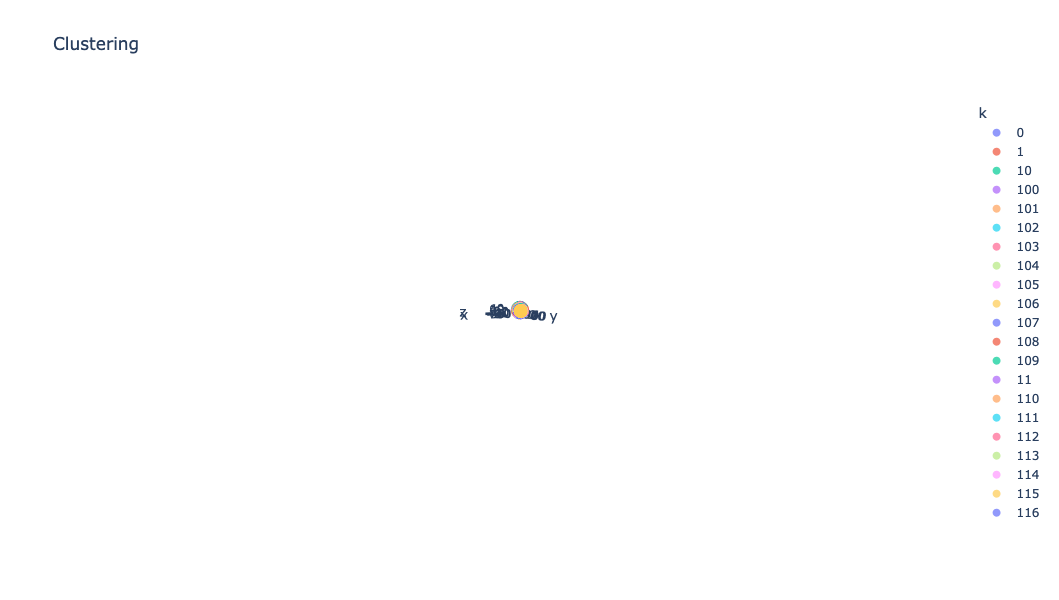

In [265]:
import plotly.express as px

fig = px.scatter_3d(
    df_k_embeddings.sort_values(["k"]),
    x="x",
    y="y",
    z="z",
    color="k",
    hover_data=["k", "label"],
    title="Clustering",
    size_max=18,
    width=1000,
    height=600,
    opacity=0.7,
)

fig.show()

In [266]:
cluster_label_df = df_k_embeddings[["k", "label"]].rename(columns={"k": "cluster"})
cluster_label_df = cluster_label_df.reset_index()

In [33]:
cluster_label_path = Path(DATASET_DIR) / "cluster_label.parquet"
# cluster_label_df.to_parquet(cluster_label_path, index=False)

In [34]:
cluster_label_df = pd.read_parquet(cluster_label_path)

cluster_label_df[~cluster_label_df["cluster"].duplicated()]["cluster"].count()

1000

In [35]:
cluster_temp_df = cluster_label_df
cluster_temp_df["label"] = cluster_temp_df["label"].str.lower()
cluster_label_series = cluster_temp_df.to_dict("series")
cluster_label_map = dict(
    zip(cluster_label_series["label"], cluster_label_series["cluster"])
)

In [36]:
def tag_to_cluster(tags_raw):
    tags = eval(tags_raw.lower())
    values = filter(
        lambda x: x is not None,
        map(
            cluster_label_map.get,
            tags,
        ),
    )
    return list(values)


df["clusters"] = df["tags"].progress_apply(tag_to_cluster)

100%|████████████████████████████████| 184478/184478 [00:02<00:00, 79286.13it/s]


In [37]:
df.head()

title  \
0               Mental Note Vol. 24   
1         Your Brain On Coronavirus   
2                    Mind Your Nose   
3          The 4 Purposes of Dreams   
4  Surviving a Rod Through the Head   

                                                text  \
0  Photo by Josh Riemer on Unsplash  Merry Christ...   
1  Your Brain On Coronavirus  A guide to the curi...   
2  Mind Your Nose  How smell training can change ...   
3  Passionate about the synergy between science a...   
4  You ve heard of him, haven t you  Phineas Gage...   

                                                 url                 authors  \
0  https://medium.com/invisible-illness/mental-no...            ['Ryan Fan']   
1  https://medium.com/age-of-awareness/how-the-pa...       ['Simon Spichak']   
2  https://medium.com/neodotlife/mind-your-nose-f...                      []   
3  https://medium.com/science-for-real/the-4-purp...  ['Eshan Samaranayake']   
4  https://medium.com/live-your-life-on-purpose/s...        ['Rishav Sinha']   

                          timestamp  \
0  2020-12-26 03:38:10.479000+00:00   
1  2020-09-23 22:10:17.126000+00:00   
2  2020-10-10 20:17:37.132000+00:00   
3  2020-12-21 16:05:19.524000+00:00   
4  2020-02-26 00:01:01.576000+00:00   

                                                tags label     score  \
0  ['Mental Health', 'Health', 'Psychology', 'Sci...    en  0.964118   
1  ['Mental Health', 'Coronavirus', 'Science', 'P...    en  0.962439   
2  ['Biotechnology', 'Neuroscience', 'Brain', 'We...    en  0.957879   
3  ['Health', 'Neuroscience', 'Mental Health', 'P...    en  0.915634   
4  ['Brain', 'Health', 'Development', 'Psychology...    en  0.914334   

     clusters  
0  [253, 251]  
1       [253]  
2       [251]  
3  [251, 253]  
4       [251]

In [38]:
cluster_temp_df[cluster_temp_df["label"] == "Mental Health".lower()]

index cluster          label
6275   6275     253  mental health

In [39]:
cluster_temp_df

index cluster                      label
0          0     476       christian leadership
1          1     498            personal energy
2          2     649        service design tips
3          3     645            travel services
4          4     633  best email marketing tips
...      ...     ...                        ...
32599  32599     656          sharing is caring
32600  32600     930           parametric tests
32601  32601      35               summer scarf
32602  32602     258       how to start youtube
32603  32603     332             celebrate life

[32604 rows x 3 columns]

In [40]:
DATASET_NAME = "label_medium_articles.parquet"
DATASET_PATH = Path(DATASET_DIR) / DATASET_NAME

df.to_parquet(DATASET_PATH)

In [41]:
df.iloc[10000]["text"]

'Photo by Artem Kniaz on Unsplash  It s that time of year again   the time when memories of loved ones past make their way to the present. A special time we love and embrace those who are  near and dear  to us. It is also the time that most of us move at breakneck speed and invite stress into our already hectic lifestyles. Emotions, the good and the not so good, are everywhere. It s Christmastime.  Feelings or emotions are the universal language and are to be honored. They are the authentic expression of who you are at your deepest place.  Judith Wright  This year, my emotions are especially raw. I feel them deeply and have found myself driving down the road, crying as I listen to songs on the radio. I m sure COVID has a lot to do with the sadness I m feeling. There has been so much loss and division during a time when people should run to each other   not away. In addition to the struggle that is COVID, I lost my brother and his daughter   only 17   in a tragic car accident. We were n